**Import Libraries**

In [1]:
# Standard Libraries
import os
import random

# Data Manipulation Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import pydicom
from PIL import Image

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split

**Define Parameters**

In [2]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/vinbigdata-chest-xray-abnormalities-detection.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/vinbigdata-chest-xray-abnormalities-detection-extracted'

# Define parameters
SEED = 42
LEARNING_RATE = 0.005
EPOCHS =  1
BATCH_SIZE = 16

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [3]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior in CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [4]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Data extracted to {extracted_path}")

# Uncomment the line below to extract data (if not already extracted)
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [5]:
# Define Disease Labels
disease_labels = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['class_name'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No finding'] = labels_df['class_name'].apply(lambda x: 1 if 'No finding' in x else 0)

    # Map image filenames to their full paths
    labels_df['Path'] = labels_df['image_id'].map(lambda x: os.path.join(image_path, 'train', f"{x}.dicom"))
    
    return labels_df

# Path to the labels CSV file
train_csv_path = os.path.join(EXTRACTED_PATH, 'train.csv')
# test_csv_path = os.path.join(EXTRACTED_PATH, 'test.csv')

# Load and preprocess the labels
train_val_df = load_labels(train_csv_path, EXTRACTED_PATH)
# test_df = load_labels(test_csv_path, EXTRACTED_PATH)

train_val_df = train_val_df[train_val_df['class_id'] != 14]

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
# print(f"Test size: {test_df.shape[0]}")

Train size: 36096


**Define Dataset for VinDr-CXR images**

In [6]:
class ChestXrayDataset(Dataset):
    """
    Custom Dataset for VinDr-CXR images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and labels
        img_path = self.df.iloc[idx]['Path']

        # Retrive image
        ds = pydicom.dcmread(img_path)
        img_array = ds.pixel_array.astype(np.float32)
        img_array = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array) + 1e-5)
        img_array = np.stack([img_array] * 3, axis=-1)
        image = Image.fromarray((img_array * 255).astype(np.uint8))

        # Retrive boxes and labels
        boxes = self.df.iloc[idx][['x_min', 'y_min', 'x_max', 'y_max']].values.astype(np.float32)
        labels = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformations
        image = self.transform(image)
        
        return image, boxes, labels

**Define Data Transformations**

In [7]:
import torchvision.transforms as transforms

# Define transformations for training data with data augmentation
train_transforms = transforms.Compose([
    
    # Convert to grayscale and replicate channels to get 3 channels
    transforms.Grayscale(num_output_channels=3),
    
    # Resize the image to 224x224
    transforms.Resize((224, 224)),
    
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    
    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [8]:
train_dataset = ChestXrayDataset(train_val_df, transform=train_transforms)
# test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Split into Training and Validation**

In [9]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

**Create DataLoaders**

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=64)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=64)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=64)

**Plot one sample from batch**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].


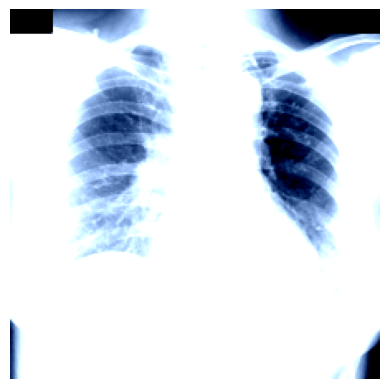

In [11]:
# Retrieve one batch of data from training loader
data_iter = iter(train_loader)
images, boxes, labels = next(data_iter)

# Select the first image
img = images[0]
label = labels[0]

# Convert to [H, W, C]
img = img.permute(1, 2, 0)

# Display
plt.imshow(img)
plt.axis('off')
plt.show()

# **Step 7: Build the Model**

**Initialize the Object Detection Model**

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


class ObjectDetectionModel(nn.Module):
    """
    Pre-trained DenseNet121 with separate classification and regression heads.
    """
    def __init__(self, num_classes=len(disease_labels)):
        super(ObjectDetectionModel, self).__init__()
        # Load pre-trained DenseNet121 model
        base_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        
        # We only use the convolutional features from DenseNet121
        self.features = base_model.features  
        # Get the number of features from DenseNet121's classifier input
        in_features = base_model.classifier.in_features
        
        # Define separate heads:
        # Classification head: predicts disease labels (multi-class)
        self.classifier = nn.Linear(in_features, num_classes)
        # Regression head: predicts 4 bounding box coordinates (x_min, y_min, x_max, y_max)
        self.regressor = nn.Linear(in_features, 4)

    def forward(self, x):
        # Extract convolutional features
        features = self.features(x)  # shape: [B, C, H, W]
        # Apply ReLU (DenseNet applies this before pooling)
        out = F.relu(features, inplace=True)
        # Global average pooling to get a feature vector of shape [B, C, 1, 1]
        out = F.adaptive_avg_pool2d(out, (1, 1))
        # Flatten to shape [B, C]
        out = torch.flatten(out, 1)
        
        # Pass the feature vector to the two heads
        class_preds = self.classifier(out)
        bbox_preds = self.regressor(out)
        
        return class_preds, bbox_preds

# Initialize the model and move it to the desired device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ObjectDetectionModel(num_classes=len(disease_labels))
model.to(device)
model = nn.DataParallel(model)

**Use Multiple GPUs**

In [13]:
model = nn.DataParallel(model)

**Define Loss Function and Optimizer**

In [14]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Regression loss for bounding boxes
reg_loss_fn = nn.SmoothL1Loss()

# Classification loss
cls_loss_fn = nn.CrossEntropyLoss()

# **Step 8: Train the Model**

In [15]:
pip install torchmetrics[detection]

Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install pycocotools

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install faster-coco-eval

Note: you may need to restart the kernel to use updated packages.


In [20]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def train_model(model, train_loader, val_loader, reg_loss_fn, cls_loss_fn, optimizer, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """

    # List to store loss and mAP
    train_losses = []
    val_losses = []
    val_mAP = []

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, boxes, labels in progress_bar:
            break
            
            inputs, boxes, labels = inputs.to(device), boxes.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            class_preds, bbox_preds = model(inputs)

            # Compute loss
            loss_bbox = reg_loss_fn(bbox_preds, boxes)
            loss_class = cls_loss_fn(class_preds, labels)
            loss = loss_bbox + loss_class

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # -----------------
        # Validation Phase
        # -----------------
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []

        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} (Val)")
        with torch.no_grad():
            for inputs, boxes, labels in progress_bar:
                inputs, boxes, labels = inputs.to(device), boxes.to(device), labels.to(device)

                class_preds, bbox_preds = model(inputs)

                loss_bbox = reg_loss_fn(bbox_preds, boxes)
                loss_class = cls_loss_fn(class_preds, labels)
                loss = loss_bbox + loss_class
                val_loss += loss.item() * inputs.size(0)

                # Get predicted labels for the batch
                pred_labels = torch.argmax(class_preds, dim=1)

                # Loop over the batch to create prediction/target dictionaries for each image.
                for i in range(inputs.size(0)):
                    # --- Prediction Dictionary ---
                    pred_box = bbox_preds[i]
                    if pred_box.ndim == 1:
                        pred_box = pred_box.unsqueeze(0)
                    confidence = class_preds[i, pred_labels[i]]
                    pred = {
                        "boxes": pred_box.cpu(),                           # Tensor of shape [N, 4]
                        "scores": confidence.unsqueeze(0).cpu(),           # Tensor of shape [N]
                        "labels": pred_labels[i].unsqueeze(0).cpu()          # Tensor of shape [N]
                    }

                    # --- Target Dictionary ---
                    gt_box = boxes[i]
                    if gt_box.ndim == 1:
                        gt_box = gt_box.unsqueeze(0)
                    
                    # Process labels: if the label tensor has more than one element (likely one-hot),
                    # convert it to a class index using argmax.
                    gt_labels = labels[i].cpu()
                    if gt_labels.ndim > 0 and gt_labels.numel() > 1:
                        gt_labels = torch.argmax(gt_labels)
                    # Ensure it is a tensor of shape [N] by unsqueezing if needed.
                    if gt_labels.ndim == 0:
                        gt_labels = gt_labels.unsqueeze(0)
                    
                    target = {
                        "boxes": gt_box.cpu(),    # Tensor of shape [N, 4]
                        "labels": gt_labels         # Tensor of shape [N]
                    }

                    all_preds.append(pred)
                    all_targets.append(target)


        # Compute average validation loss
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        # -----------------
        # mAP Calculation using TorchMetrics
        # -----------------
        # mAP@0.5:0.95 (default IoU thresholds)
        metric_default = MeanAveragePrecision()
        metric_default.update(all_preds, all_targets)
        result_default = metric_default.compute()
        mAP_default = result_default["map"]
        print(f"Epoch {epoch+1} - mAP@0.5:0.95: {mAP_default:.4f}")

        # mAP@0.5 (IoU threshold fixed at 0.5)
        metric_50 = MeanAveragePrecision(iou_thresholds=[0.5])
        metric_50.update(all_preds, all_targets)
        result_50 = metric_50.compute()
        mAP_50 = result_50["map"]
        print(f"Epoch {epoch+1} - mAP@0.5: {mAP_50:.4f}")

        # Save mAP from default metric
        val_mAP.append(mAP_default)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, mAP@0.5:0.95: {mAP_default:.4f}")

    return train_losses, val_losses, val_mAP

# Example usage:
train_losses, val_losses, val_mAP = train_model(model, train_loader, val_loader, reg_loss_fn, cls_loss_fn, optimizer, epochs=EPOCHS)

Epoch 1/1 (Val): 100%|██████████| 452/452 [02:22<00:00,  3.18it/s]


Epoch 1 - mAP@0.5:0.95: 0.0000
Epoch 1 - mAP@0.5: 0.0000
Epoch 1/1 - Train Loss: 0.0000, Val Loss: 471.5876, mAP@0.5:0.95: 0.0000


# **Step 8: Evaluate the Model**

In [ ]:
# TODO